In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import itertools
import random
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import r2_score


In [25]:
# Create all possible combinations of Shift, Line, Product.
shifts = ['Morning', 'Afternoon', 'Night']
production_lines = ['A', 'B', 'C']
product_types = ['A', 'B', 'C', 'D']

# Define the start and end date of the year
start_date = datetime.datetime(2022, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
days_diff = (end_date - start_date).days


cycle_time_range = (100, 150)
downtime_range = (50, 100)
maintenance_cost_range = (50, 150)

In [45]:
# Initialize an empty list to store the manufacturing data
manufacturing_data = []

for i in range(10000):
    random_date = start_date + timedelta(days=random.randint(0, days_diff))
    Date = random_date
    
    shift = random.choice(shifts)
    
    line = random.choice(production_lines)
    
    product = random.choice(product_types)
    
    # Generate a random batch number
    batch_number = random.randint(1, 10)

    # Generate random yield, scrap, and rework rates that sum to 1
    yield_data = round(random.uniform(0.85, 0.98), 2)
    scrap_data = round(random.uniform(0.01, 1 - yield_data), 2)
    rework_data = round(1 - yield_data - scrap_data, 2)

    # Generate random cycle time, downtime, and maintenance cost
    cycle_time = random.randint(*cycle_time_range)
    downtime = random.randint(*downtime_range)
    maintenance_cost = random.randint(*maintenance_cost_range)

    # Append the record to the manufacturing data list
    manufacturing_data.append([random_date, shift, line, product, batch_number, yield_data, scrap_data, rework_data, cycle_time, downtime, maintenance_cost])

In [54]:
# convert the list of lists to a pandas dataframe
columns = ["Date", "Shift", "Line", "Product", "Batch", "Yield", "Scrap", "Rework", "CycleTime", "Downtime", "MaintenanceCost"]
df = pd.DataFrame(manufacturing_data, columns=columns)

df = df.sort_values('Date').reset_index(drop = True)
df


,Date,Shift,Line,Product,Batch,Yield,Scrap,Rework,CycleTime,Downtime,MaintenanceCost
0,2022-01-01,Morning,B,B,6,0.90,0.08,0.02,119,94,131
1,2022-01-01,Afternoon,B,A,9,0.95,0.03,0.02,110,97,88
2,2022-01-01,Morning,C,C,1,0.93,0.05,0.02,101,97,135
3,2022-01-01,Morning,C,C,1,0.87,0.10,0.03,115,75,97
4,2022-01-01,Afternoon,A,A,8,0.93,0.06,0.01,128,56,123
...,...,...,...,...,...,...,...,...,...,...,...
9995,2022-12-31,Morning,C,D,2,0.92,0.03,0.05,130,92,71
9996,2022-12-31,Night,B,A,8,0.97,0.01,0.02,138,52,61
9997,2022-12-31,Afternoon,A,B,7,0.93,0.07,-0.00,106,64,95
9998,2022-12-31,Morning,A,B,9,0.96,0.02,0.02,114,58,123


In [55]:
# df.to_csv('manufacturing_data.csv', index=False)


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             10000 non-null  datetime64[ns]
 1   Shift            10000 non-null  object        
 2   Line             10000 non-null  object        
 3   Product          10000 non-null  object        
 4   Batch            10000 non-null  int64         
 5   Yield            10000 non-null  float64       
 6   Scrap            10000 non-null  float64       
 7   Rework           10000 non-null  float64       
 8   CycleTime        10000 non-null  int64         
 9   Downtime         10000 non-null  int64         
 10  MaintenanceCost  10000 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(3)
memory usage: 859.5+ KB


# Summary statistics of the data


In [57]:
print(df.describe())

              Batch         Yield         Scrap        Rework     CycleTime  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       5.521400      0.914777      0.047387      0.037836    124.781000   
std        2.856599      0.037709      0.030615      0.031201     14.546333   
min        1.000000      0.850000      0.010000     -0.000000    100.000000   
25%        3.000000      0.880000      0.020000      0.010000    112.000000   
50%        6.000000      0.910000      0.040000      0.030000    124.000000   
75%        8.000000      0.950000      0.070000      0.060000    137.000000   
max       10.000000      0.980000      0.150000      0.140000    150.000000   

           Downtime  MaintenanceCost  
count  10000.000000     10000.000000  
mean      75.129400       100.462200  
std       14.835554        29.184988  
min       50.000000        50.000000  
25%       62.000000        75.000000  
50%       75.000000       100.000000  
75%       88.00

In [207]:
# Convert 'Yield', 'Scrap', and 'Rework' columns to percentages
df['Yield'] = df['Yield'] * 100
df['Scrap'] = df['Scrap'] * 100
df['Rework'] = df['Rework'] * 100

# Visualize the distributions of the variables


<AxesSubplot:xlabel='Line', ylabel='Count'>

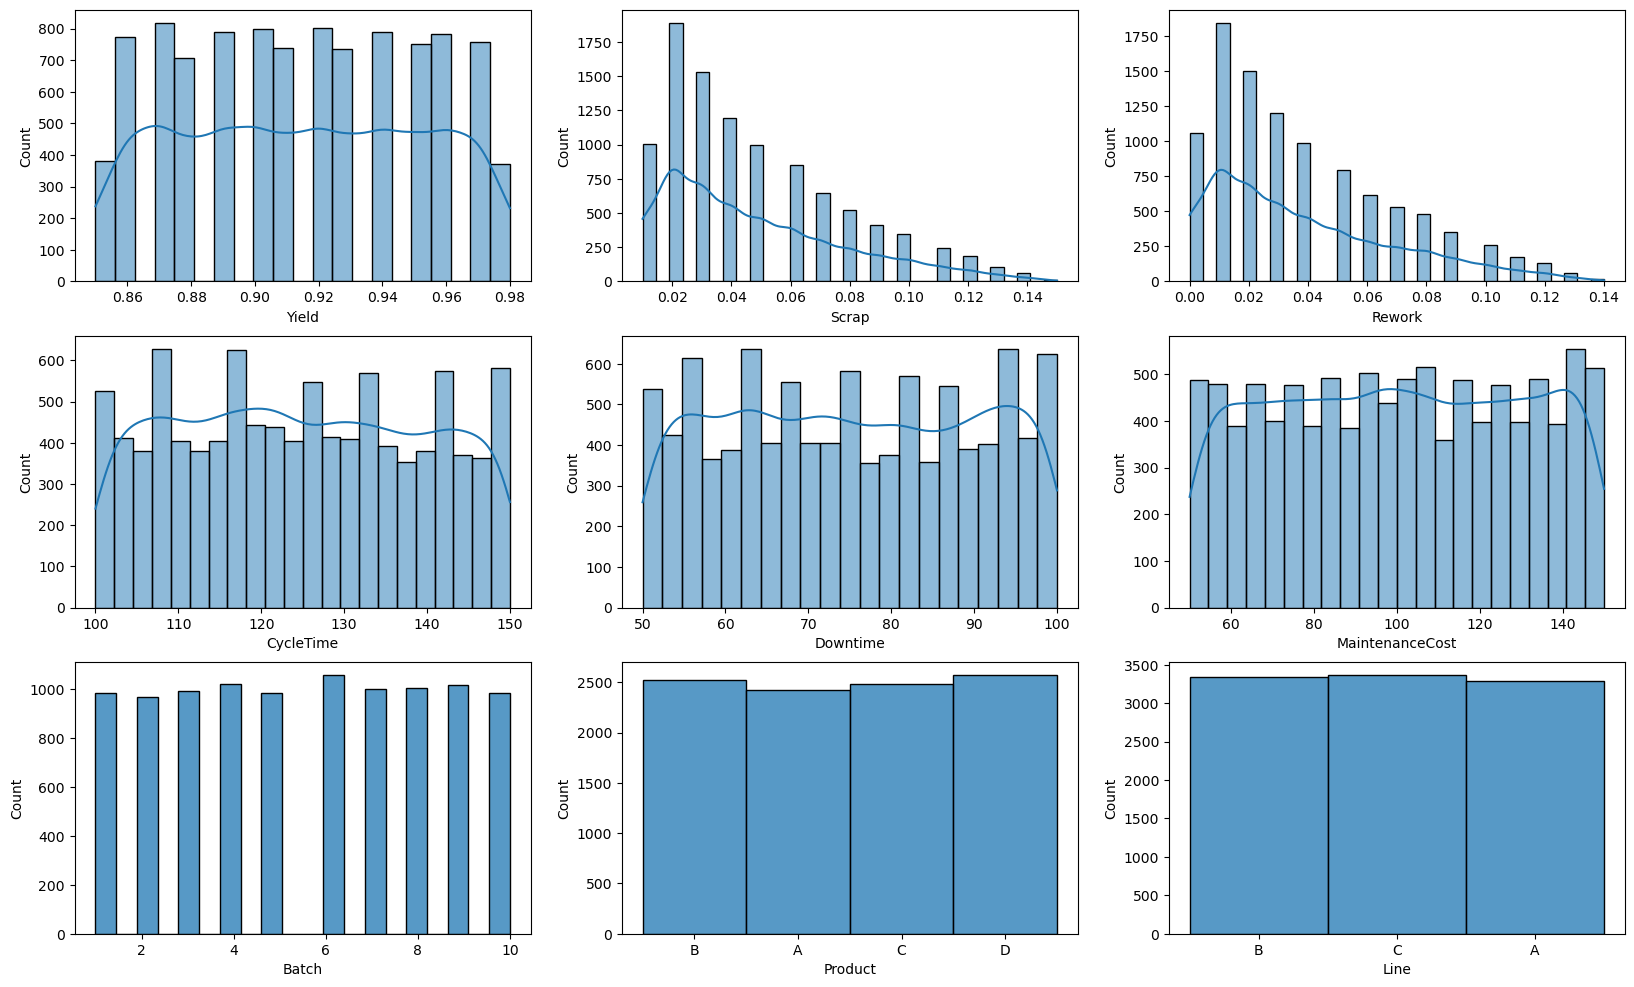

In [296]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20, 12))
sns.histplot(data=df, x='Yield', kde=True, ax=axs[0][0])
sns.histplot(data=df, x='Scrap',  kde=True,ax=axs[0][1])
sns.histplot(data=df, x='Rework',kde=True, ax=axs[0][2])
sns.histplot(data=df, x='CycleTime',kde=True, ax=axs[1][0])
sns.histplot(data=df, x='Downtime',kde=True, ax=axs[1][1])
sns.histplot(data=df, x='MaintenanceCost',kde=True, ax=axs[1][2])
sns.histplot(data=df, x='Batch', ax=axs[2][0])
sns.histplot(data=df, x='Product', ax=axs[2][1])
sns.histplot(data=df, x='Line', ax=axs[2][2])


# Visualize the correlation between variables


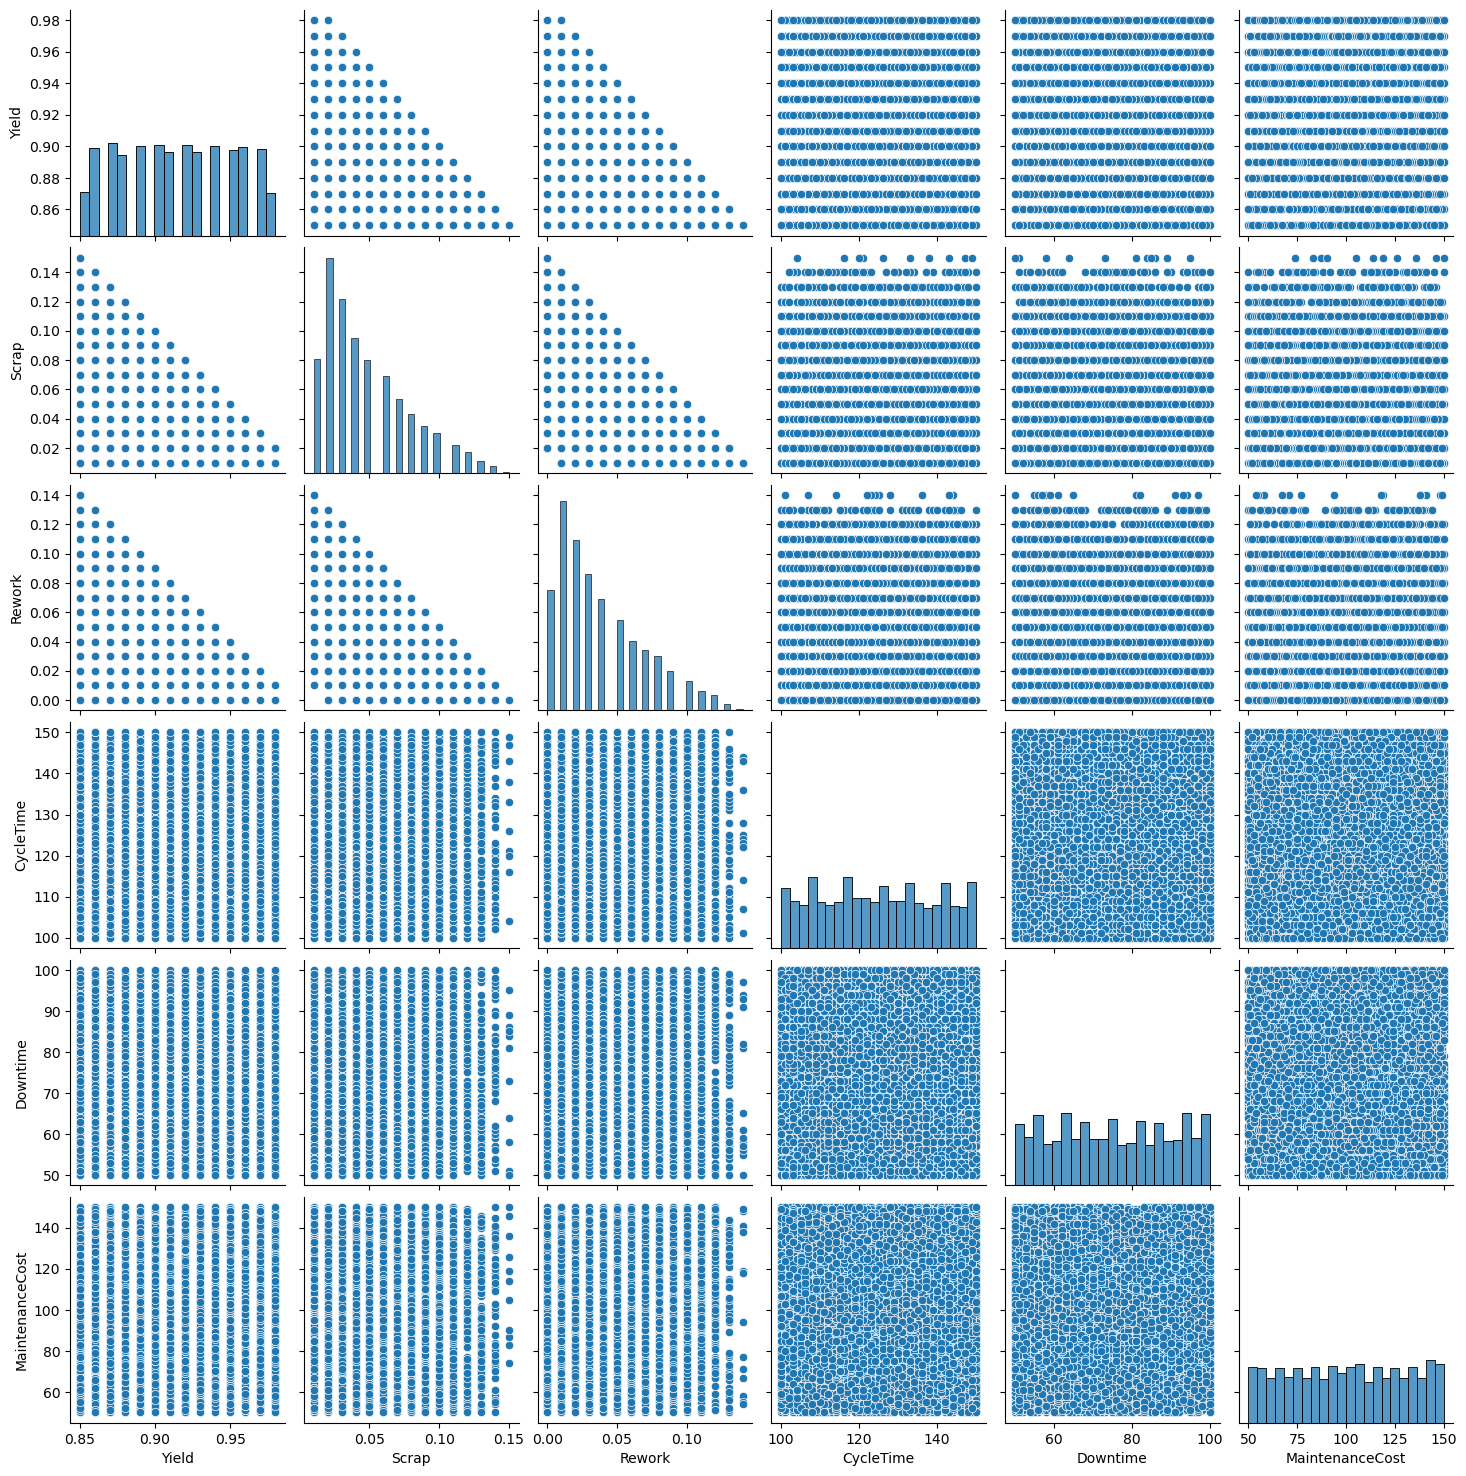

In [297]:
sns.pairplot(df, vars=["Yield", "Scrap", "Rework", "CycleTime", "Downtime", "MaintenanceCost"])
plt.show()


                    Batch     Yield     Scrap    Rework  CycleTime  Downtime  \
Batch            1.000000 -0.009477  0.010972  0.000688   0.027529 -0.000922   
Yield           -0.009477  1.000000 -0.600154 -0.619689   0.004307  0.001501   
Scrap            0.010972 -0.600154  1.000000 -0.255879   0.001354 -0.006529   
Rework           0.000688 -0.619689 -0.255879  1.000000  -0.006533  0.004591   
CycleTime        0.027529  0.004307  0.001354 -0.006533   1.000000  0.004221   
Downtime        -0.000922  0.001501 -0.006529  0.004591   0.004221  1.000000   
MaintenanceCost -0.013685  0.001597 -0.002269  0.000297  -0.020237  0.004378   

                 MaintenanceCost  
Batch                  -0.013685  
Yield                   0.001597  
Scrap                  -0.002269  
Rework                  0.000297  
CycleTime              -0.020237  
Downtime                0.004378  
MaintenanceCost         1.000000  


<AxesSubplot:>

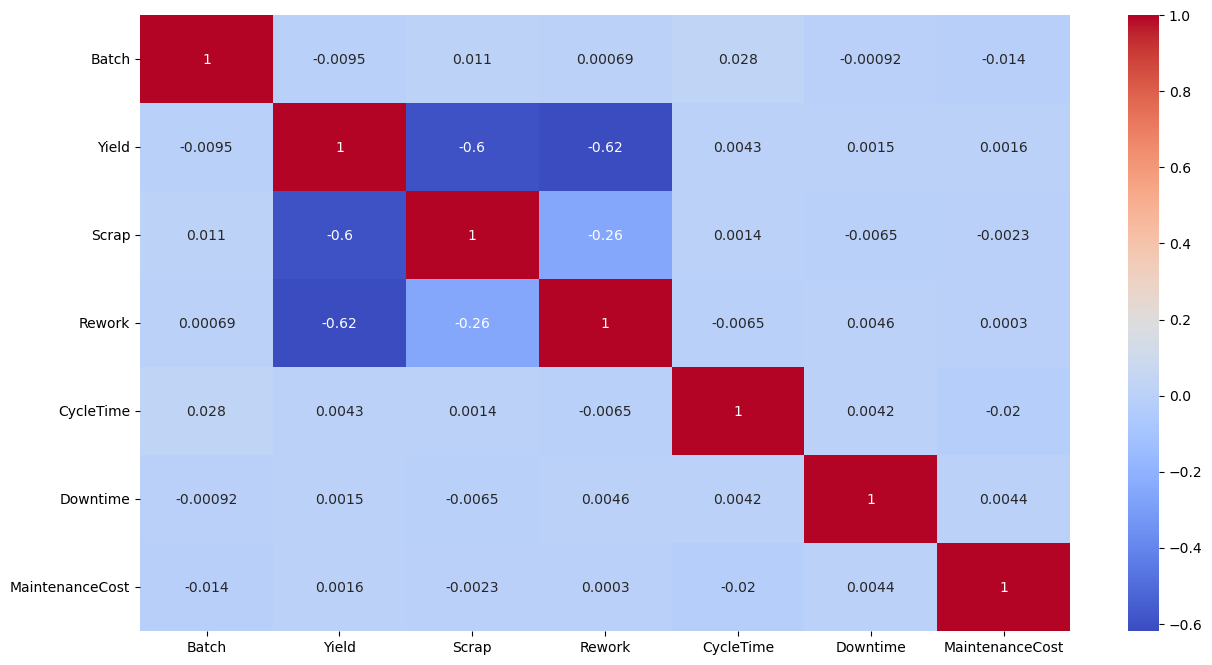

In [330]:
# Calculate correlation matrix
corr_matrix = df.corr()

print(corr_matrix)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

## Calculate KPIs by date


In [74]:
kpi_df = df.groupby('Date').agg({
    'Yield': 'mean',
    'Scrap': 'mean',
    'Rework': 'mean',
    'CycleTime': 'mean',
    'Downtime': 'mean',
    'MaintenanceCost': 'mean'
})

In [323]:
kpi_df

,Yield,Scrap,Rework,CycleTime,Downtime,MaintenanceCost
Date,,,,,,
2022-01-01,91.031250,5.156250,3.812500,129.500000,80.000000,101.687500
2022-01-02,92.935484,4.032258,3.032258,125.096774,78.225806,99.225806
2022-01-03,92.400000,4.350000,3.250000,123.200000,74.700000,94.550000
2022-01-04,90.350000,5.100000,4.550000,125.900000,76.450000,97.700000
2022-01-05,91.419355,5.193548,3.387097,124.774194,77.838710,108.838710
...,...,...,...,...,...,...
2022-12-27,90.521739,4.826087,4.652174,122.695652,76.043478,109.086957
2022-12-28,91.130435,5.043478,3.826087,124.304348,71.608696,106.086957
2022-12-29,91.241379,4.482759,4.275862,126.379310,75.551724,104.551724


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

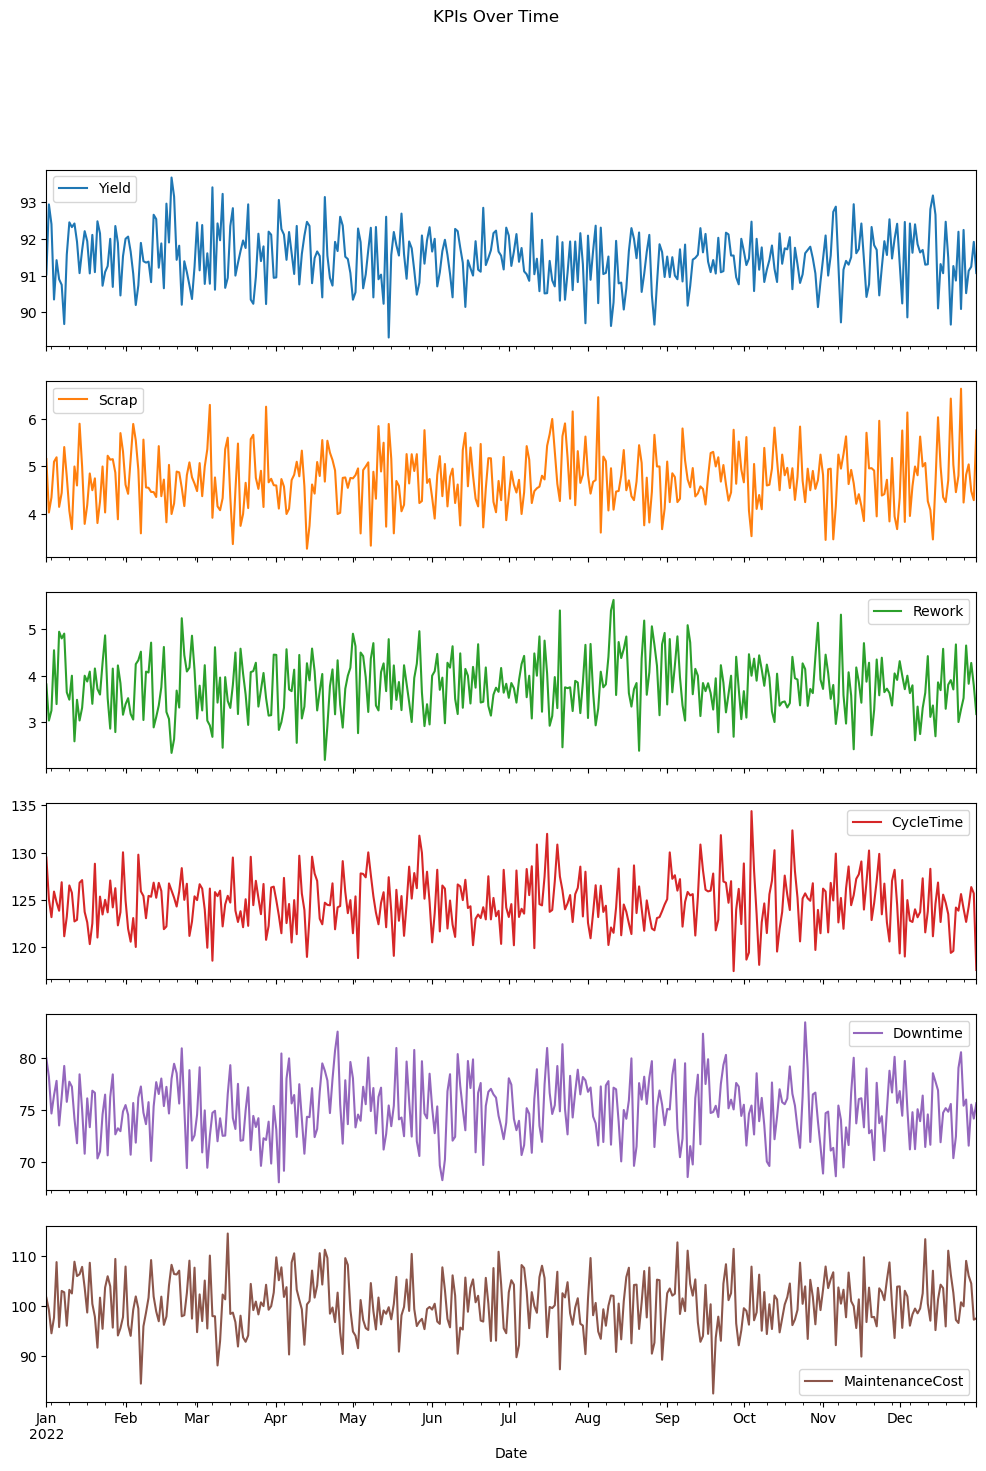

In [147]:
kpi_df.plot(subplots=True, figsize=(12, 16), title='KPIs Over Time')


## Plot KPIs by production line with Downtime


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

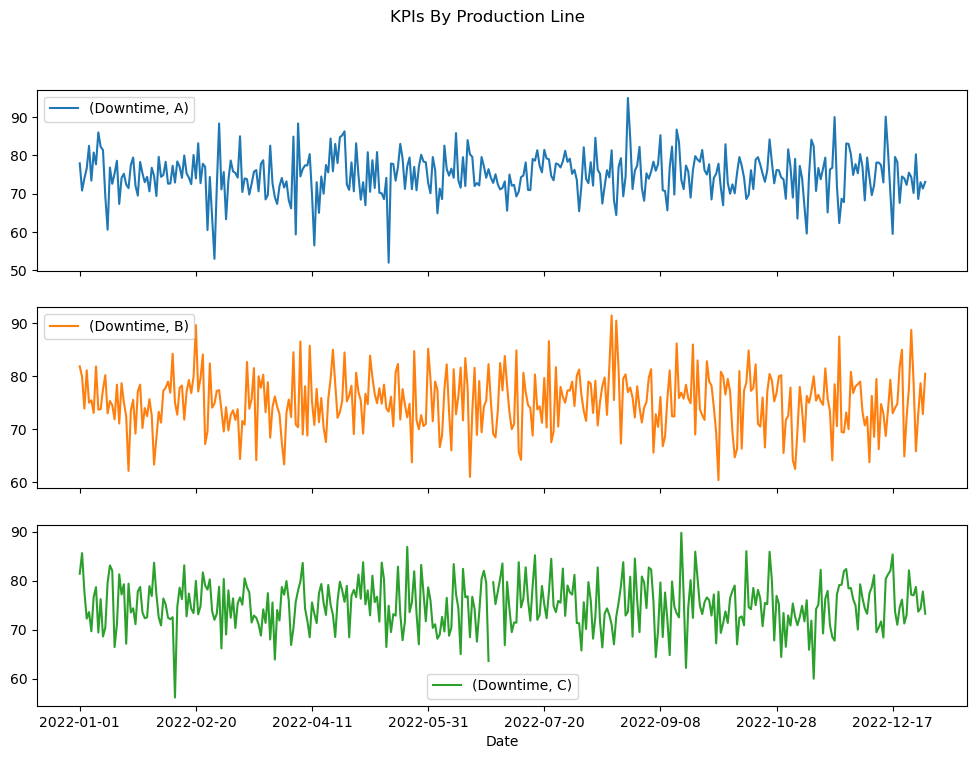

In [300]:

line_kpi_df = df.groupby(['Date', 'Line']).agg({
    'Downtime': 'mean',
}).unstack(level=-1)
line_kpi_df.plot(subplots=True, figsize=(12, 8), title='KPIs By Production Line')

In [324]:
line_kpi_df

Downtime                      
Line                A          B          C
Date                                       
2022-01-01  77.928571  81.875000  81.400000
2022-01-02  70.833333  79.888889  85.600000
2022-01-03  74.000000  73.900000  77.750000
2022-01-04  76.600000  81.142857  72.250000
2022-01-05  82.500000  75.000000  73.583333
...               ...        ...        ...
2022-12-27  80.300000  65.833333  78.714286
2022-12-28  68.625000  72.888889  73.666667
2022-12-29  73.000000  78.700000  74.307692
2022-12-30  71.375000  72.857143  77.777778
2022-12-31  73.090909  80.500000  73.250000

[365 rows x 3 columns]

# Plot KPIs by product type with Scrap


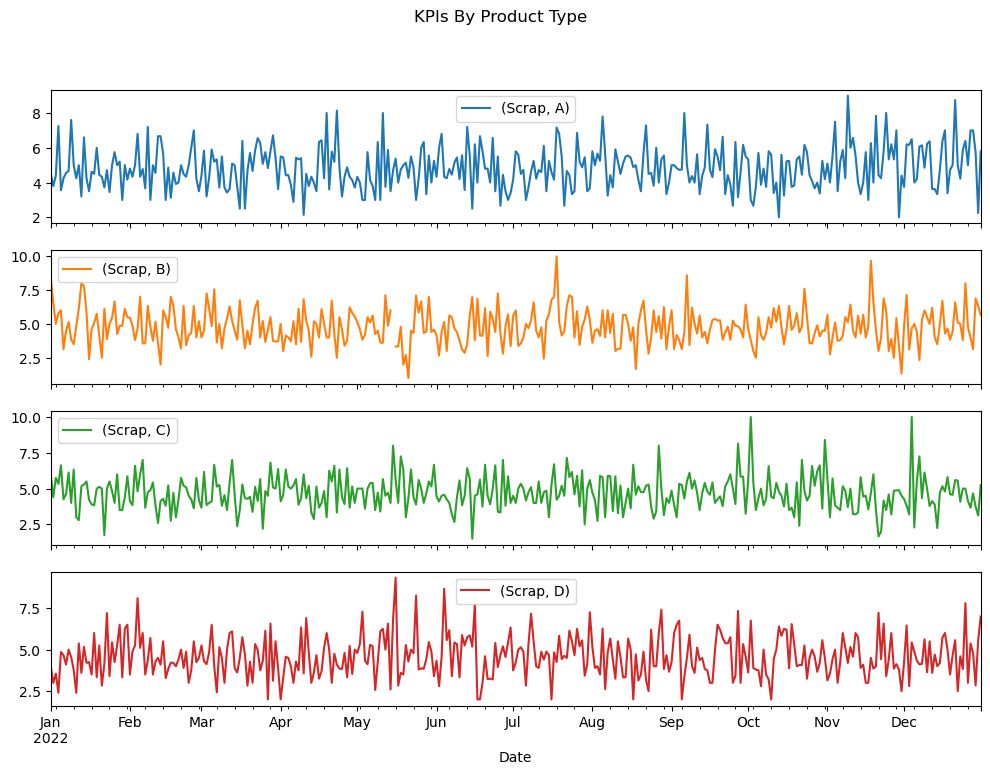

In [208]:
product_kpi_df = df.groupby(['Date', 'Product']).agg({
    'Scrap': 'mean',
}).unstack(level=-1)
product_kpi_df.plot(subplots=True, figsize=(12, 8), title='KPIs By Product Type')

# Show plots
plt.show()



## Decompose the Scrap rate into trend, seasonal, and residual components


Populating the interactive namespace from numpy and matplotlib


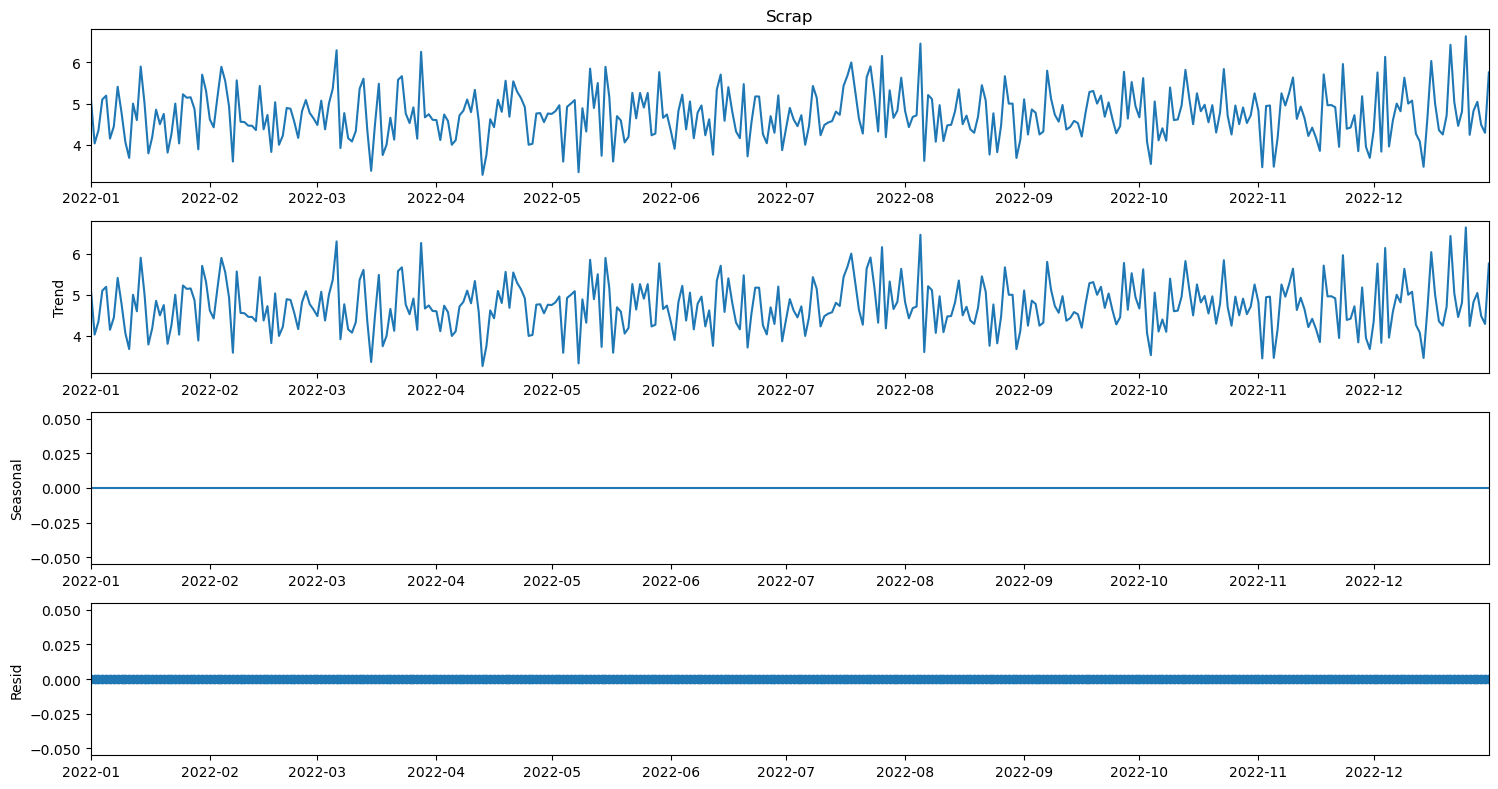

Augmented Dickey-Fuller test for Scrap :
Statistic value = -19.525375
p-value = 0.000000 
No. of lags: 0 


In [301]:
%pylab inline

scrap_kpi = data.groupby(['Date'])['Scrap'].mean()

decomposition_scrap = seasonal_decompose(scrap_kpi, model='additive', period=1)
decomposition_scrap.plot()
plt.show()

# Decomposing the varibales into trend, sesionality and residual for better analysis

result= adfuller(scrap_kpi)
print('Augmented Dickey-Fuller test for %s :\nStatistic value = %5f\np-value = %5f \nNo. of lags: %d '\
          % ('Scrap', result[0], result[1], result[2]))


From the results of Dickey-Fuller test, it can be observed that the choosen variable are stationary,



# Build a Auto reg model

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


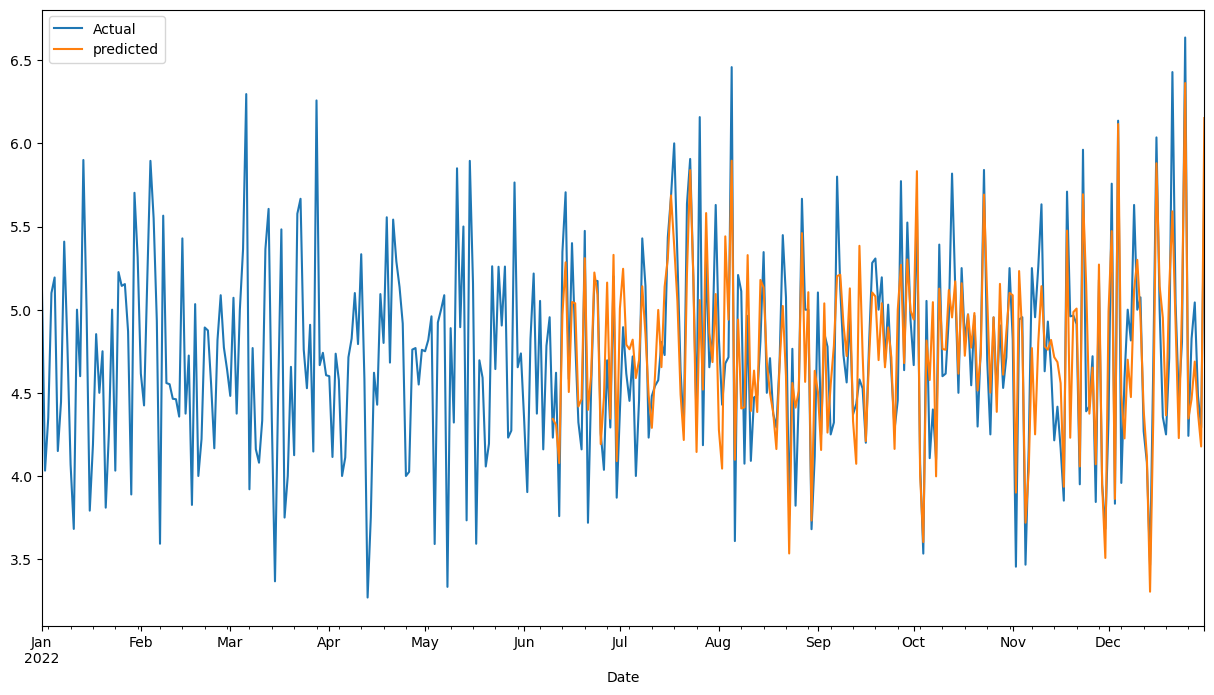

In [302]:
model_scrap_percent = AutoReg(scrap_kpi, lags=170).fit()

scrap_kpi_predict = model_scrap_percent.predict(start=0, end=len(scrap_kpi)-1,dynamic=False)
scrap_kpi.plot(label = 'Actual' )
scrap_kpi_predict.plot(label = 'predicted')
plt.legend()
plt.show()

## The R2 score of the model is

In [265]:
r2_score(scrap_kpi[170:], scrap_kpi_predict[170:])

0.6967968827564002

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


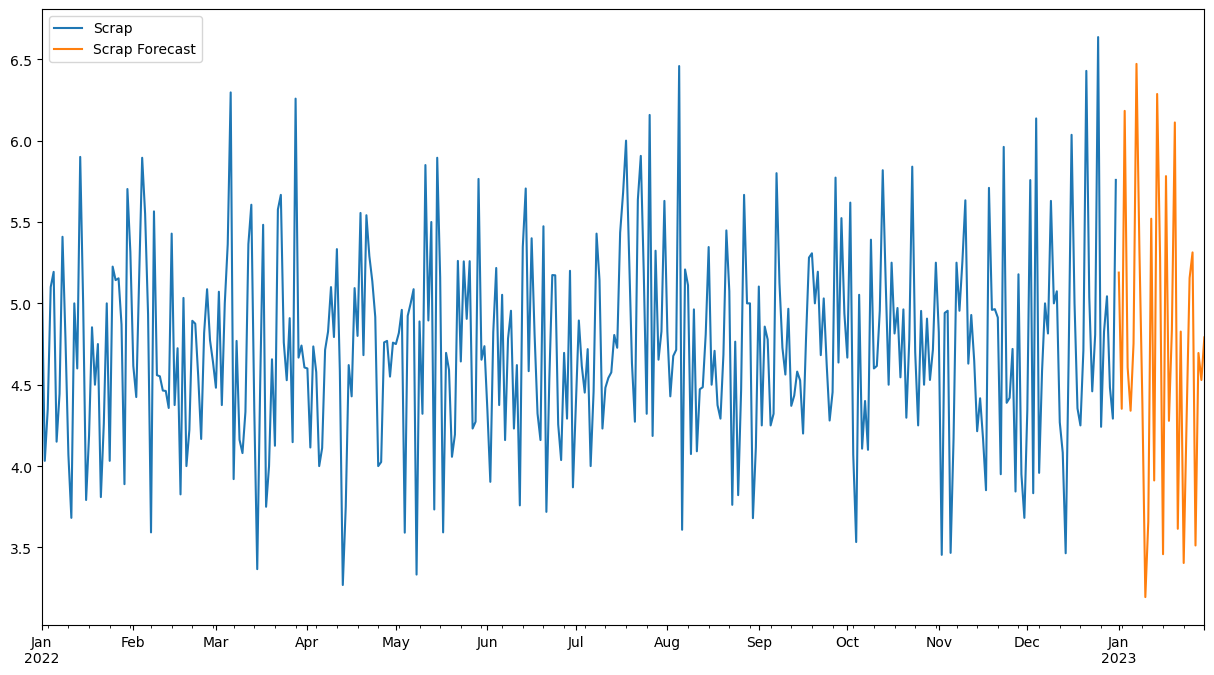

In [222]:
# Forecast future values
forecast_scrap_percent = model_scrap_percent.forecast(steps=30)

# Combine actual and forecasted values in one dataframe
scrap_kpi_forecast = pd.concat([scrap_kpi, forecast_scrap_percent.rename('Scrap Forecast')], axis=1)

# Plot the actual and forecasted values
scrap_kpi_forecast.plot()
plt.show()


# KPI 2: Average Downtime by Line and Date:
# Decompose the Downtime into trend, seasonal, and residual components


Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['mod']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


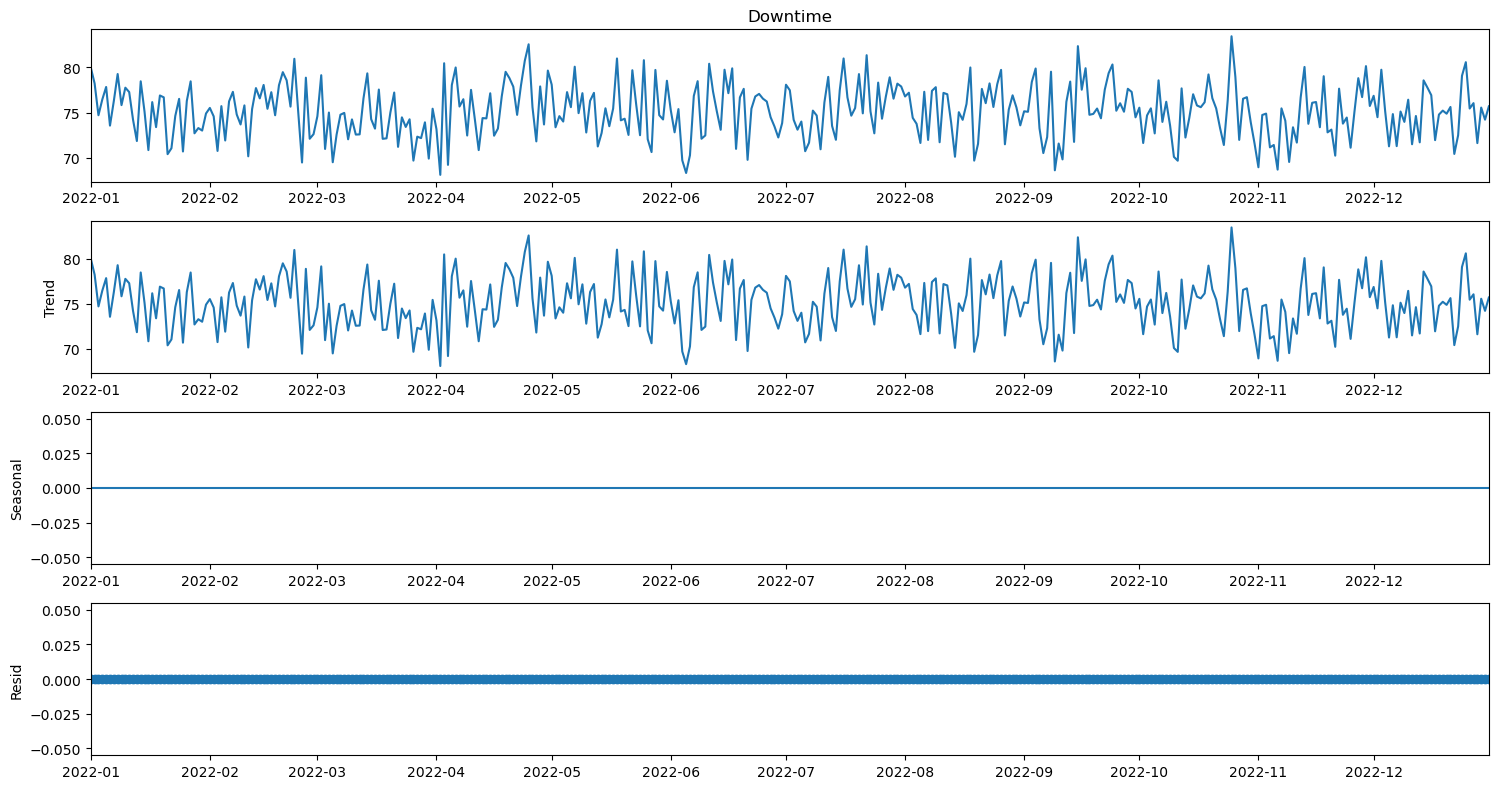

Augmented Dickey-Fuller test for Downtime :
Statistic value = -17.428719
p-value = 0.000000 
No. of lags: 0 


In [285]:
%pylab inline

Downtime_kpi = data.groupby(['Date'])['Downtime'].mean()

decomposition_Downtime = seasonal_decompose(Downtime_kpi, model='additive', period=1)
decomposition_Downtime.plot()
plt.show()

# Decomposing the varibales into trend, sesionality and residual for better analysis

result= adfuller(Downtime_kpi)
print('Augmented Dickey-Fuller test for %s :\nStatistic value = %5f\np-value = %5f \nNo. of lags: %d '\
          % ('Downtime', result[0], result[1], result[2]))


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


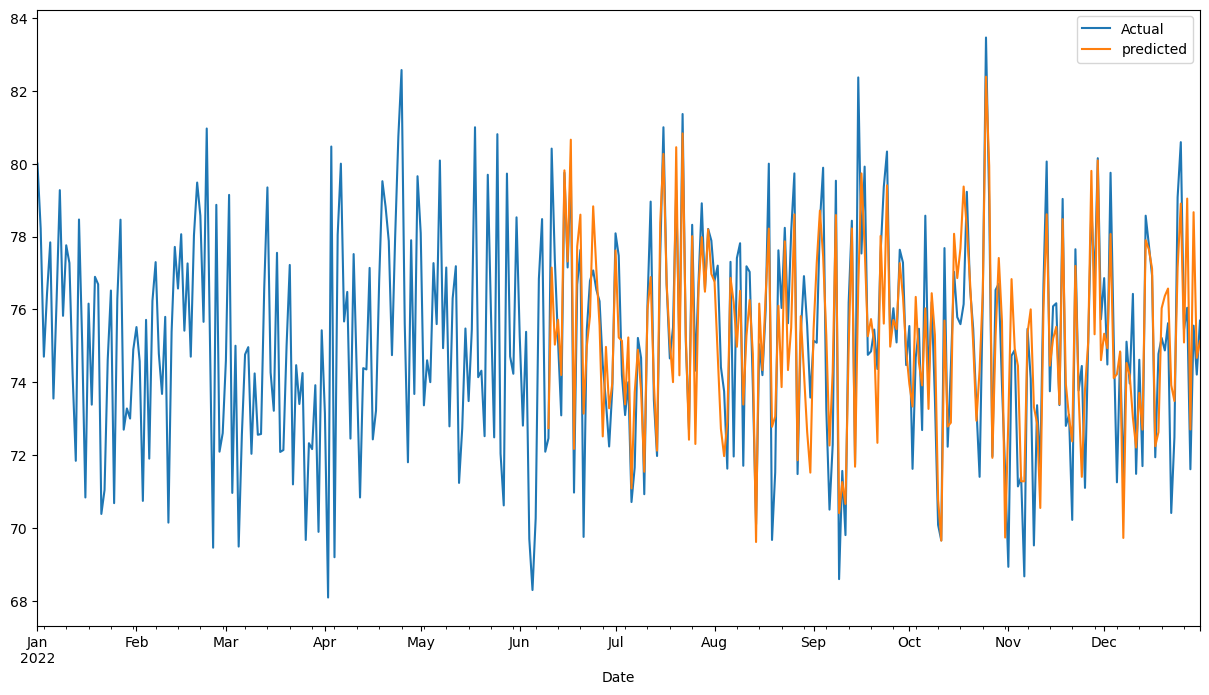

In [327]:
model_Downtime_percent = AutoReg(Downtime_kpi, lags=160).fit()

Downtime_kpi_predict = model_Downtime_percent.predict(start=0, end=len(Downtime_kpi)-1,dynamic=False)
Downtime_kpi.plot(label = 'Actual' )
Downtime_kpi_predict.plot(label = 'predicted')
plt.legend()
plt.show()

# R2 score of auto reg model is

In [328]:
r2_score(Downtime_kpi[160:], Downtime_kpi_predict[160:])

0.7122603291574929

# # Forecast future values


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


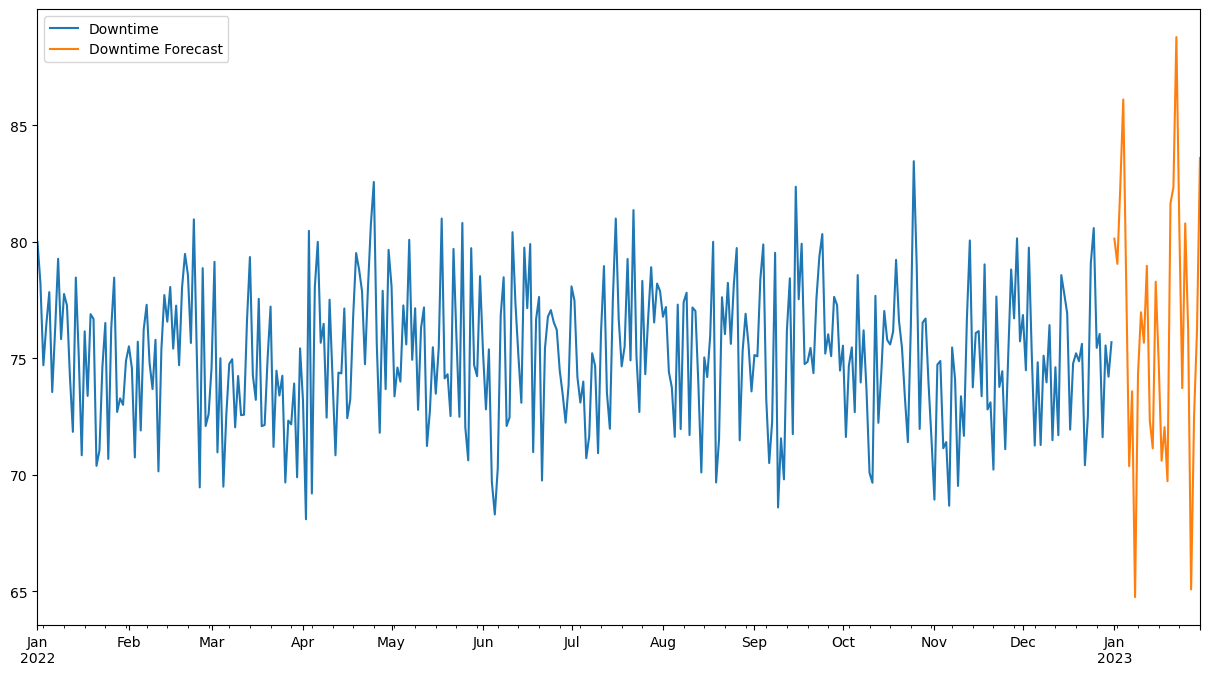

In [329]:
forecast_Downtime_percent = model_Downtime_percent.forecast(steps=30)

# Combine actual and forecasted values in one dataframe
Downtime_kpi_forecast = pd.concat([Downtime_kpi, forecast_Downtime_percent.rename('Downtime Forecast')], axis=1)

# Plot the actual and forecasted values
Downtime_kpi_forecast.plot()
plt.show()
